In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import random
import time
from gurobipy import *
import warnings
import matplotlib.pyplot as plt

## Baseline Model Formulation

### Sets and Indices

$i \in I$: Index and set of Kiosks locations ~ i = 1,...,N.

$j \in J$: Index and set of residential estate locations where there's customer demand ~ j = 1,...,M.


### Parameters

$B \in \mathbb{R}^+$: Fixed cost of purchasing a shared car(assume it to be fixed).

$K_{i} \in \mathbb{R}^+$: Fixed cost associated with constructing Kiosks $i \in I$.

$capacity_{i} \in \mathbb{R}^+$: Max capicity of each Kiosks $i \in I$.

$demand_{j} \in \mathbb{R}^+$: Demand of each residential estate location $j \in J$.

$arcs_{i,j} \in \mathbb{R}^+$: Distance between Kiosk $i \in I$ and residential location $j \in J$.

$cost_{i,j} \in \mathbb{R}^+$: Cost of travelling between Kiosk $i \in I$ and customer location $j \in J$. We assume that this cost is proportional to the distance between the Kiosk and the customer. That is, $cost_{i,j} = cost\_per\_unit\_distance \cdot arcs_{i,j}$, where cost_per_unit_distance is the cost per mile of driving in average over 5 years (despite the time, location etc).

### Decision Variables

$x_{i} \in \{0, 1 \}$: Decision to build kiosk i.This variable is equal to 1 if we build a Kiosk station at candidate location $i \in I$; and 0 otherwise.

$y_{i,j}$: Expected number of customers from each residential estate $j \in J$ to kiosk $i \in I$.



### Objective Function

- **Total costs**. We want to minimize the total cost to setting up kiosks. This is the sum of the cost of constructing kiosks, purchasing cars, and the cost related to traveling between kiosks and customers.

\begin{equation}
\text{Min} \quad Z = \sum_{i=1}^N K_{i} \cdot x_{i} + \sum_{(i,j)\in arcs} (B\cdot y_{ij} + cost_{ij} \cdot y_{ij})
\end{equation}


### Constraints

- **Demand**. For each residential location  $j \in J$ ensure that its demand is fulfilled. 

\begin{equation}
\sum_{i=1}^Ny_{ij} \geq demand_j, ~ j = 1,...,M\\
\end{equation}

- **Binary Constraints**. No demand fulfilled by kiosks that are not built. Decision to build kiosk is binary, where W = 1000 as a big number.

\begin{equation}
\sum_{j=1}^My_{ij} \leq Wx_i, ~ i = 1,...,N\\
x_{i} \in \{0, 1 \}
\end{equation}

- **Kiosk Capacity**. For each kiosk  $i \in I$, Supply of each kiosk i must be less than equal to maximum capacity.

\begin{equation}
\sum_{j=1}^My_{ij} \leq capacity_i, ~ i = 1,...,N\\
y_{ij}\geq 0, x_{i} \in \{0, 1 \}
\end{equation}

- **Non-Negative Constraints**. Demand from residences to kiosk must be greater than or equals to zero.

\begin{equation}
y_{ij}\geq 0 
\end{equation}


#### Data Preparation

In [39]:
# Reading in data
df_distance = pd.read_csv(r'.\data_for_code\arc_distance.csv')
df_residences = pd.read_csv(r'.\data_for_code\residences_data.csv')
df_kiosks = pd.read_excel(r'.\data_for_code\kiosks_data_base.xlsx')

# Demand Calculation
population_in_region = 123020
sg_license_holders = 1968283
sg_private_cars = 555540
sg_population = 3240800

proportion_no_car = (sg_license_holders - sg_private_cars)/sg_population
proportion_demand = 0.03 

# Assuming that population is evenly spread out in all residences
no_of_residences = df_distance.nunique()['source_postal']
demand_avg = np.round((population_in_region * proportion_no_car * proportion_demand)/no_of_residences)
df_residences['demand'] = demand_avg

# aggregating demand data to building level to reduce arcs
df_demand = df_residences.groupby('BUILDING')[['LATITUDE','LONGITUDE','demand']].agg({'LATITUDE':'first','LONGITUDE':'first','demand':'sum'}).reset_index()
df_demand_id = df_demand.reset_index().rename(columns={'index':'RESIDENCE_ID'})
df_demand_geog = df_demand_id[['RESIDENCE_ID','BUILDING','LATITUDE','LONGITUDE','demand']]
df_demand_geog['GROUP'] = 'demand'

# kiosk data preparation
df_kiosks_id = df_kiosks.reset_index().rename(columns={'index':'KIOSK_ID'})
df_kiosks_geog = df_kiosks_id[['KIOSK_ID','POSTAL','LATITUDE','LONGITUDE']]
df_kiosks_geog['GROUP'] = 'kiosks'

# Checking demand is less than max capacity for it to be feasible
print(df_demand.demand.sum())
print(df_kiosks.MAX_CAPACITY.sum())

## Calculating distance from demand to kiosks
df_merged = df_distance.merge(df_residences, how='left', left_on = 'source_postal', right_on='POSTAL')
df_arc_distance1 = df_merged.groupby(['BUILDING','dest_postal'])[['total_time','total_distance']].agg(
    {'total_time':'mean','total_distance':'mean'}).reset_index()

## Labelling Kiosks & Residences
required_cols = ['BUILDING','dest_postal','total_time','total_distance','RESIDENCE_ID','KIOSK_ID']
df_arc_distance = df_arc_distance1.merge(df_demand_geog, how='inner',on='BUILDING')
df_arc_distance2 = df_arc_distance.merge(df_kiosks_geog, how='inner',left_on='dest_postal',right_on='POSTAL')
df_travel_cost = df_arc_distance2[required_cols]

## Calculation distance cost
cost_per_unit_distance = 1
df_travel_cost['travel_cost'] = df_travel_cost['total_distance']* cost_per_unit_distance

# generate arcs, cost
dict = df_travel_cost[['KIOSK_ID','RESIDENCE_ID', 'travel_cost']].reset_index().to_dict('index')
result = {(dict[i]['KIOSK_ID'], dict[i]['RESIDENCE_ID']): dict[i]['travel_cost'] for i in range(0, len(dict))}
arcs, cost = multidict(result)

1590.0
4997


C:\Users\weiji\AppData\Local\Continuum\anaconda3\envs\r-tutorial\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\weiji\AppData\Local\Continuum\anaconda3\envs\r-tutorial\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### Tableau Lat Long Data Output (All)

In [53]:
df_geog = pd.concat([df_demand_geog, df_kiosks_geog]).reset_index(drop=True)
df_geog.to_csv('./output/all_demand_and_kiosks.csv')

#### Input data for baseline model

In [3]:
N = df_kiosks.shape[0] #kiosks
M = df_demand.shape[0] #residential locations

# W is large number (bigM)
W=1000 

# cost of car $80K
B = 80000

# max capacity of a Kiosk
capacity = list(df_kiosks_id['MAX_CAPACITY'])  # assume fixed capacity 50 for all N kiosks locations, this is a list of size N.
   
# Fixed cost of $550,000 for each kiosk regardless of capacity
K = list(df_kiosks_id['FIXED_COST']) # This is a list of size N

# demand per residential locations generate random demand around average
demand = list(df_demand_id['demand'])

In [4]:
print('W:',W,'\n')
print('N:',N,'\n')
print('M:',M,'\n')
print('K:',K,'\n')
print('B:',B,'\n')
print('capacity:',capacity,'\n')
print('no. of arcs:', len(arcs),'\n')

W: 1000 

N: 76 

M: 54 

K: [550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000, 550000] 

B: 80000 

capacity: [68, 68, 53, 68, 55, 62, 69, 55, 63, 71, 53, 72, 68, 61, 56, 56, 59, 60, 74, 62, 72, 51, 74, 75, 57, 68, 75, 58, 63, 67, 58, 59, 62, 65, 68, 66, 74, 58, 64, 75, 62, 63, 66, 68, 73, 62, 59, 73, 51, 70, 72, 72, 64, 64, 70, 69, 65, 74, 54, 51, 53, 64, 72, 64, 70, 73, 75, 60, 72, 53, 64, 74, 63, 51, 75, 150] 

no. of arcs: 4102 



In [5]:

#########Model Set-up############

m= Model("blueSG")

# Creat variables
x = m.addVars(N,vtype=GRB.BINARY, name = "x")
y = m.addVars(N,M,lb=0,vtype= GRB.INTEGER, name = "y")

# set objective
m.setObjective( quicksum(K[i]*x[i] for i in range(N)) + 
               quicksum( B*y[i,j] for (i,j) in arcs) + 
               quicksum(cost[i,j]*y[i,j] for (i,j) in arcs), GRB.MINIMIZE)

# demand constraint: 
m.addConstrs(( quicksum(y[i,j] for (i,j) in arcs.select('*',j)) >= demand[j] for j in range(M) ), name = "demand")

# capcity constraint: 
m.addConstrs(( quicksum(y[i,j] for (i,j) in arcs.select(i,'*')) <= capacity[i] for i in range(N) ), name = "capacity")

# binary constraints: 
m.addConstrs(( quicksum(y[i,j] for (i,j) in arcs.select(i,'*')) <= W*x[i] for i in range(N) ), name = "binary")

#Supressing the optimization output
m.setParam( 'OutputFlag', False )
    
# Solving the model
m.optimize()

print("\n Minimum cost:")
print('Obj:', m.objVal)

Using license file C:\gurobi902\gurobi.lic
Academic license - for non-commercial use only

 Minimum cost:
Obj: 139465144.4804659


In [6]:
#  Print kiosks that are chosen & obtain a list of kiosk index
kiosk_list = []
kiosk_counter = 0

for v in x:    
    if x[v].x > 0.001:
        print(x[v].VarName, x[v].x)
        kiosk_list.append(v)
        kiosk_counter+=1

print(f'Total number of kiosks selected: {kiosk_counter}')

x[9] 1.0
x[18] 1.0
x[23] 1.0
x[25] 1.0
x[26] 1.0
x[29] 1.0
x[36] 1.0
x[39] 1.0
x[44] 1.0
x[47] 1.0
x[49] 1.0
x[50] 1.0
x[53] 1.0
x[54] 1.0
x[55] 1.0
x[57] 1.0
x[66] 1.0
x[68] 1.0
x[71] 1.0
x[74] 1.0
x[75] 1.0
Total number of kiosks selected: 21


In [7]:
# print the number of demand to each kiosk
for v in y:    
    if y[v].x > 0.001:
        print(y[v].VarName, y[v].x)

y[9,6] 21.0
y[9,21] 3.0
y[9,38] 27.0
y[9,40] 2.0
y[9,53] 18.0
y[18,0] 23.0
y[18,15] 27.0
y[18,30] 24.0
y[23,0] 5.0
y[23,10] 15.0
y[23,11] 13.0
y[23,17] 24.0
y[23,39] 18.0
y[25,0] 68.0
y[26,11] 14.0
y[26,14] 24.0
y[26,27] 10.0
y[26,28] 27.0
y[29,4] 27.0
y[29,27] 4.0
y[29,35] 21.0
y[29,42] 15.0
y[36,19] 10.0
y[36,29] 12.0
y[36,43] 4.0
y[36,45] 36.0
y[36,50] 12.0
y[39,9] 14.0
y[39,25] 30.0
y[39,26] 30.0
y[39,27] 1.0
y[44,12] 2.0
y[44,20] 24.0
y[44,43] 29.0
y[44,51] 18.0
y[47,12] 46.0
y[47,34] 27.0
y[49,1] 33.0
y[49,9] 10.0
y[49,33] 27.0
y[50,2] 27.0
y[50,18] 24.0
y[50,31] 21.0
y[53,5] 1.0
y[53,7] 3.0
y[53,13] 45.0
y[53,30] 15.0
y[54,5] 35.0
y[54,37] 23.0
y[54,52] 12.0
y[55,36] 24.0
y[55,37] 3.0
y[55,46] 18.0
y[55,49] 24.0
y[57,3] 27.0
y[57,37] 25.0
y[57,40] 22.0
y[66,2] 3.0
y[66,41] 12.0
y[66,44] 60.0
y[68,47] 27.0
y[68,48] 30.0
y[68,52] 15.0
y[71,19] 8.0
y[71,32] 45.0
y[71,42] 21.0
y[74,16] 36.0
y[74,29] 39.0
y[75,1] 12.0
y[75,8] 3.0
y[75,22] 51.0
y[75,23] 36.0
y[75,24] 33.0
y[75,41] 15.

#### Tableau Data: Output lat long of demand nodes & chosen kiosks

In [36]:


# print the number of demand to each kiosk
results = []
for v in y:    
    if y[v].x > 0.001:
        print(y[v].VarName, y[v].x)
#         pair = y[v].VarName
#         demand = y[v].x
#         results = list(zip(y[v].VarName,y[v].x))  
        results = zip(y[v].VarName , y[v].x)


y[9,6] 21.0


TypeError: zip argument #2 must support iteration

In [43]:
df_demand_geog

,RESIDENCE_ID,BUILDING,LATITUDE,LONGITUDE,demand,GROUP
0,0,BEAUTY GARDEN,1.391332,103.901193,96.0,demand
1,1,CORALINUS,1.403719,103.906138,45.0,demand
2,2,DAMAI GROVE,1.404610,103.908666,30.0,demand
3,3,EASTDALE,1.397319,103.916019,27.0,demand
4,4,ECOPOLITAN,1.400958,103.897804,27.0,demand
5,5,EDGEDALE GREEN,1.400815,103.913562,36.0,demand
6,6,FLO RESIDENCE,1.391847,103.913039,21.0,demand
7,7,OASIS TERRACES,1.402635,103.913271,3.0,demand
8,8,ONE PUNGGOL,1.408618,103.905088,3.0,demand
9,9,PARC CENTROS,1.403470,103.904495,24.0,demand


In [40]:
df_demand_geog

,RESIDENCE_ID,BUILDING,LATITUDE,LONGITUDE,demand,GROUP
0,0,BEAUTY GARDEN,1.391332,103.901193,96.0,demand
1,1,CORALINUS,1.403719,103.906138,45.0,demand
2,2,DAMAI GROVE,1.404610,103.908666,30.0,demand
3,3,EASTDALE,1.397319,103.916019,27.0,demand
4,4,ECOPOLITAN,1.400958,103.897804,27.0,demand
5,5,EDGEDALE GREEN,1.400815,103.913562,36.0,demand
6,6,FLO RESIDENCE,1.391847,103.913039,21.0,demand
7,7,OASIS TERRACES,1.402635,103.913271,3.0,demand
8,8,ONE PUNGGOL,1.408618,103.905088,3.0,demand
9,9,PARC CENTROS,1.403470,103.904495,24.0,demand


In [41]:
df_selected_kiosks = df_kiosks_geog[df_kiosks_geog.KIOSK_ID.isin(kiosk_list)]
df_baseline_geog = pd.concat([df_demand_geog, df_selected_kiosks]).reset_index(drop=True)
df_baseline_geog.to_csv('./output/baseline_kiosks.csv')

## Extended Model 1 Formulation: Variable Kiosk Cost

### Parameters

$B \in \mathbb{R}^+$: Fixed cost of purchasing a shared car(assume it to be fixed).

$K_{i} \in \mathbb{R}^+$: Fixed cost associated with constructing Kiosks $i \in I$.

$capacity_{i} \in \mathbb{R}^+$: Max capicity of each Kiosks $i \in I$.

$demand_{j} \in \mathbb{R}^+$: Demand of each residential estate location $j \in J$.

$arcs_{i,j} \in \mathbb{R}^+$: Distance between Kiosk $i \in I$ and residential location $j \in J$.

$cost_{i,j} \in \mathbb{R}^+$: Cost of travelling between Kiosk $i \in I$ and customer location $j \in J$. We assume that this cost is proportional to the distance between the Kiosk and the customer. That is, $cost_{i,j} = cost\_per\_unit\_distance \cdot arcs_{i,j}$, where cost_per_unit_distance is the cost per mile of driving in average over 5 years (despite the time, location etc).

<span style='color:Blue'>$z_{i} \in \{0, 1 \}$: The cost per lot in each kiosk $i \in I$.</span>


### Decision Variables

$x_{i} \in \{0, 1 \}$: Decision to build kiosk i.This variable is equal to 1 if we build a Kiosk station at candidate location $i \in I$; and 0 otherwise.

$y_{i,j}$: Expected number of customers from each residential estate $j \in J$ to kiosk $i \in I$.

<span style='color:Blue'>$s_{i}$: Number of cars at each kiosk $i \in I$.</span>


### Objective Function

- <span style='color:Blue'>**Total costs**. We want to minimize the total cost to setting up kiosks. This is the sum of the cost of constructing kiosks, purchasing cars, and the cost related to traveling between kiosks and customers.

\begin{equation}
\text{Min} \quad Z = \sum_{i=1}^N K_{i} \cdot x_{i} + \sum_{i=1}^N z_{i} \cdot s_{i} + \sum_{(i,j)\in arcs} (B\cdot y_{ij} + cost_{ij} \cdot y_{ij})
\end{equation}
</span>

### Constraints

- **Demand**. For each residential location  $j \in J$ ensure that its demand is fulfilled. 

\begin{equation}
\sum_{i=1}^Ny_{ij} \geq demand_j, ~ j = 1,...,M\\
\end{equation}

- **Binary Constraints**. No demand fulfilled by kiosks that are not built. Decision to build kiosk is binary.

\begin{equation}
\sum_{j=1}^My_{ij} \leq Wx_i, ~ i = 1,...,N\\
x_{i} \in \{0, 1 \}
\end{equation}

- <span style='color:Blue'>**Kiosk Supply Constraints**. For each kiosk  $i \in I$ Supply of each kiosk i, $s_{i}$ must be greater than or equal to to kiosk i.</span>

\begin{equation}
\sum_{j=1}^My_{ij} = s_{i}, ~ i = 1,...,N\\
\end{equation}

- <span style='color:Blue'>**Kiosk Maximum Capacity Constraints**. For each kiosk  $i \in I$ Supply of each kiosk i, $s_{i}$ must be equal to maximum capacity.</span>

\begin{equation}
s_{i}\leq capacity_i, ~ i = 1,...,N\\
\end{equation}

- <span style='color:Blue'>**Non-Negative Constraints**. Demand from residences to kiosk & supply at each kiosk must be greater than or equals to zero.</span>

\begin{equation}
y_{ij}\geq 0, s_{i} \geq 0
\end{equation}



In [60]:
# Reading in data
df_distance = pd.read_csv(r'.\data_for_code\arc_distance.csv')
df_residences = pd.read_csv(r'.\data_for_code\residences_data.csv')
df_kiosks = pd.read_excel(r'.\data_for_code\kiosks_data_extended.xlsx')

# Demand Calculation
population_in_region = 123020
sg_license_holders = 1968283
sg_private_cars = 555540
sg_population = 3240800

proportion_no_car = (sg_license_holders - sg_private_cars)/sg_population
proportion_demand = 0.03 

# Assuming that population is evenly spread out in all residences
no_of_residences = df_distance.nunique()['source_postal']
demand_avg = np.round((population_in_region * proportion_no_car * proportion_demand)/no_of_residences)
df_residences['demand'] = demand_avg

# aggregating demand data to building level to reduce arcs
df_demand = df_residences.groupby('BUILDING')[['LATITUDE','LONGITUDE','demand']].agg({'LATITUDE':'first','LONGITUDE':'first','demand':'sum'}).reset_index()
df_demand_id = df_demand.reset_index().rename(columns={'index':'RESIDENCE_ID'})
df_demand_geog = df_demand_id[['RESIDENCE_ID','BUILDING','LATITUDE','LONGITUDE']]
df_demand_geog['GROUP'] = 'demand'

# kiosk data preparation
df_kiosks_id = df_kiosks.reset_index().rename(columns={'index':'KIOSK_ID'})
df_kiosks_geog = df_kiosks_id[['KIOSK_ID','POSTAL','LATITUDE','LONGITUDE']]
df_kiosks_geog['GROUP'] = 'kiosks'

# Checking demand is less than max capacity for it to be feasible
print(f'Total Demand: {df_demand.demand.sum()}')
print(f'Total Capacity: {df_kiosks.MAX_CAPACITY.sum()}')


## Calculating distance from demand to kiosks
df_merged = df_distance.merge(df_residences, how='left', left_on = 'source_postal', right_on='POSTAL')
df_arc_distance = df_merged.groupby(['BUILDING','dest_postal'])[['total_time','total_distance']].agg(
    {'total_time':'mean','total_distance':'mean'}).reset_index()

## Labelling Kiosks & Residences
required_cols = ['BUILDING','dest_postal','total_time','total_distance','RESIDENCE_ID','KIOSK_ID']
df_arc_distance1 = df_arc_distance.merge(df_demand_geog, how='inner',on='BUILDING')
df_arc_distance2 = df_arc_distance1.merge(df_kiosks_geog, how='inner',left_on='dest_postal',right_on='POSTAL')
df_travel_cost = df_arc_distance2[required_cols]

## Calculation distance cost
cost_per_unit_distance = 1
df_travel_cost['travel_cost'] = df_travel_cost['total_distance']* cost_per_unit_distance

# generate arcs, cost
dict = df_travel_cost[['KIOSK_ID','RESIDENCE_ID', 'travel_cost']].reset_index().to_dict('index')
result = {(dict[i]['KIOSK_ID'], dict[i]['RESIDENCE_ID']): dict[i]['travel_cost'] for i in range(0, len(dict))}
arcs, cost = multidict(result)

Total Demand: 1590.0
Total Capacity: 4997


C:\Users\Tan Jie Qiang\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Tan Jie Qiang\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [61]:
N = df_kiosks_id.shape[0] #kiosks
M = df_demand_geog.shape[0] #residential locations

# W is large number (bigM)
W=1000 

# cost of car $80K
B = 80000

# max capacity of a Kiosk
capacity = list(df_kiosks_id['MAX_CAPACITY'])  # assume fixed capacity 50 for all N kiosks locations, this is a list of size N.
   
# Cost per lot at each kiosk ranges about $9000 to $14000 dependant of location
# Fixed Cost of kiosk ranges about $50000 to $150000 dependant of location
K = list(df_kiosks_id['FIXED_COST']) # This is a list of size N
Z = list(df_kiosks_id['COST_PER_LOT']) # This is a list of size N

# demand per residential locations generate random demand around average
demand = list(df_demand_id['demand'])

dict = df_travel_cost[['KIOSK_ID','RESIDENCE_ID', 'travel_cost']].reset_index().to_dict('index')
result = {(dict[i]['KIOSK_ID'], dict[i]['RESIDENCE_ID']): dict[i]['travel_cost'] for i in range(0, len(dict))}
arcs, cost = multidict(result)

In [62]:

#########Model Set-up############

m= Model("blueSG")

# Creat variables
x = m.addVars(N,vtype=GRB.BINARY, name = "x")
y = m.addVars(N,M,lb=0,vtype= GRB.INTEGER, name = "y")
s = m.addVars(N, vtype=GRB.INTEGER, name="s")

# set objective
m.setObjective( quicksum(K[i]*x[i] for i in range(N)) + 
               quicksum(Z[i]*s[i] for i in range(N)) +
               quicksum(B*y[i,j] for (i,j) in arcs) + 
               quicksum(cost[i,j]*y[i,j] for (i,j) in arcs), GRB.MINIMIZE)

# demand constraint: 
m.addConstrs(( quicksum(y[i,j] for (i,j) in arcs.select('*',j)) >= demand[j] for j in range(M) ), name = "demand")

# binary constraints: 
m.addConstrs(( quicksum(y[i,j] for (i,j) in arcs.select(i,'*')) <= W*x[i] for i in range(N) ), name = "binary")

# max capcity constraint: 
m.addConstrs(( s[i] <= capacity[i] for i in range(N) ), name = "max capacity")

# capcity constraint: 
m.addConstrs(( quicksum(y[i,j] for (i,j) in arcs.select(i,'*')) == s[i] for i in range(N) ), name = "capacity")

#Supressing the optimization output
m.setParam( 'OutputFlag', False )
    
# Solving the model
m.optimize()

print("\n Minimum cost:")
print('Obj:', m.objVal)


 Minimum cost:
Obj: 147069020.37743342


In [63]:
#  Print kiosks that are chosen & obtain a list of kiosk index
kiosk_list = []
kiosk_counter = 0

for v in x:    
    if x[v].x > 0.001:
        print(x[v].VarName, x[v].x)
        kiosk_list.append(v)
        kiosk_counter+=1
        
print(f'Total number of kiosks selected: {kiosk_counter}')

x[2] 1.0
x[4] 1.0
x[9] 1.0
x[10] 1.0
x[11] 1.0
x[18] 1.0
x[20] 1.0
x[21] 1.0
x[22] 1.0
x[24] 1.0
x[25] 1.0
x[31] 1.0
x[34] 1.0
x[35] 1.0
x[38] 1.0
x[43] 1.0
x[46] 1.0
x[47] 1.0
x[50] 1.0
x[52] 1.0
x[55] 1.0
x[64] 1.0
x[67] 1.0
x[70] 1.0
x[73] 1.0
Total number of kiosks selected: 25


In [64]:
# print the number of demand to each kiosk
for v in y:    
    if y[v].x > 0.001:
        print(y[v].VarName, y[v].x)

y[2,0] 24.0
y[2,11] 23.0
y[2,27] 6.0
y[4,26] 29.0
y[4,27] 9.0
y[9,3] 27.0
y[9,6] 21.0
y[9,21] 3.0
y[9,49] 2.0
y[9,53] 18.0
y[10,15] 27.0
y[10,37] 4.0
y[10,49] 22.0
y[11,0] 72.0
y[18,5] 35.0
y[18,30] 39.0
y[20,5] 1.0
y[20,37] 47.0
y[20,48] 24.0
y[21,1] 13.0
y[21,9] 24.0
y[21,39] 14.0
y[22,10] 15.0
y[22,11] 4.0
y[22,17] 24.0
y[22,33] 27.0
y[22,39] 4.0
y[24,25] 30.0
y[24,28] 27.0
y[25,4] 23.0
y[25,14] 24.0
y[25,35] 21.0
y[31,29] 51.0
y[31,42] 8.0
y[34,16] 15.0
y[34,19] 18.0
y[34,43] 2.0
y[34,45] 21.0
y[34,50] 12.0
y[35,16] 21.0
y[35,32] 45.0
y[38,4] 4.0
y[38,26] 1.0
y[38,42] 28.0
y[38,43] 31.0
y[43,8] 3.0
y[43,24] 5.0
y[43,41] 27.0
y[43,44] 33.0
y[46,12] 2.0
y[46,20] 24.0
y[46,45] 15.0
y[46,51] 18.0
y[47,12] 46.0
y[47,34] 27.0
y[50,1] 32.0
y[50,2] 16.0
y[50,18] 24.0
y[52,2] 14.0
y[52,13] 18.0
y[52,31] 21.0
y[52,44] 11.0
y[55,36] 24.0
y[55,46] 18.0
y[55,47] 27.0
y[64,7] 3.0
y[64,22] 51.0
y[64,44] 16.0
y[67,13] 27.0
y[67,48] 6.0
y[67,52] 27.0
y[70,23] 36.0
y[70,24] 28.0
y[73,38] 27.0
y[73,4

In [65]:
# print the number of demand to each kiosk
for v in s:    
    if s[v].x > 0.001:
        print(s[v].VarName, s[v].x)

s[2] 53.0
s[4] 38.0
s[9] 71.0
s[10] 53.0
s[11] 72.0
s[18] 74.0
s[20] 72.0
s[21] 51.0
s[22] 74.0
s[24] 57.0
s[25] 68.0
s[31] 59.0
s[34] 68.0
s[35] 66.0
s[38] 64.0
s[43] 68.0
s[46] 59.0
s[47] 73.0
s[50] 72.0
s[52] 64.0
s[55] 69.0
s[64] 70.0
s[67] 60.0
s[70] 64.0
s[73] 51.0


#### Tableau Data: Output lat long of demand nodes & chosen kiosks

In [66]:
df_selected_kiosks = df_kiosks_geog[df_kiosks_geog.KIOSK_ID.isin(kiosk_list)]
df_baseline_geog = pd.concat([df_demand_geog, df_selected_kiosks]).reset_index(drop=True)
df_baseline_geog.to_csv('./output/extended_1_kiosks.csv')

## Extended Model 2 Formulation: Distance Constraint

### Parameters

$B \in \mathbb{R}^+$: Fixed cost of purchasing a shared car(assume it to be fixed).

$K_{i} \in \mathbb{R}^+$: Fixed cost associated with constructing Kiosks $i \in I$.

$capacity_{i} \in \mathbb{R}^+$: Max capicity of each Kiosks $i \in I$.

$demand_{j} \in \mathbb{R}^+$: Demand of each residential estate location $j \in J$.

$arcs_{i,j} \in \mathbb{R}^+$: Distance between Kiosk $i \in I$ and residential location $j \in J$.

$cost_{i,j} \in \mathbb{R}^+$: Cost of travelling between Kiosk $i \in I$ and customer location $j \in J$. We assume that this cost is proportional to the distance between the Kiosk and the customer. That is, $cost_{i,j} = cost\_per\_unit\_distance \cdot arcs_{i,j}$, where cost_per_unit_distance is the cost per mile of driving in average over 5 years (despite the time, location etc).

$z_{i} \in \{0, 1 \}$: The cost per lot in each kiosk $i \in I$.

<span style='color:Blue'>$T_{i,j} \in \mathbb{R}^+$: Linear distance between Kiosk $i \in I$ and customer location $j \in J$.</span>

### Decision Variables

$x_{i} \in \{0, 1 \}$: Decision to build kiosk i.This variable is equal to 1 if we build a Kiosk station at candidate location $i \in I$; and 0 otherwise.

$y_{i,j}$: Expected number of customers from each residential estate $j \in J$ to kiosk $i \in I$.

$s_{i}$: Number of cars at each kiosk $i \in I$.

<span style='color:Blue'>$w_{i} \in \{0, 1 \}$:  Decision for residents to walk from residential estate $j \in J$ to each kiosk $i \in I$; and 0 otherwise.</span>


### Objective Function

- **Total costs**. We want to minimize the total cost to setting up kiosks. This is the sum of the cost of constructing kiosks, purchasing cars, and the cost related to traveling between kiosks and customers.

\begin{equation}
\text{Min} \quad Z = \sum_{i=1}^N K_{i} \cdot x_{i} + \sum_{i=1}^N z_{i} \cdot s_{i} + \sum_{(i,j)\in arcs} (B\cdot y_{ij} + cost_{ij} \cdot y_{ij})
\end{equation}


### Constraints

- **Demand**. For each residential location  $j \in J$ ensure that its demand is fulfilled. 

\begin{equation}
\sum_{i=1}^Ny_{ij} \geq demand_j, ~ j = 1,...,M\\
\end{equation}

- **Binary Constraints**. No demand fulfilled by kiosks that are not built. Decision to build kiosk is binary.

\begin{equation}
\sum_{j=1}^My_{ij} \leq Wx_i, ~ i = 1,...,N\\
x_{i} \in \{0, 1 \}
\end{equation}

- **Kiosk Supply Constraints**. For each kiosk  $i \in I$ Supply of each kiosk i, $s_{i}$ must be greater than or equal to to kiosk i.

\begin{equation}
\sum_{j=1}^My_{ij} = s_{i}, ~ i = 1,...,N\\
\end{equation}

- **Kiosk Maximum Capacity Constraints**. For each kiosk  $i \in I$ Supply of each kiosk i, $s_{i}$ must be equal to maximum capacity.

\begin{equation}
s_{i}\leq capacity_i, ~ i = 1,...,N\\
\end{equation}

- <span style='color:Blue'>**Residential-Kiosk Distance Constraints**. For each chosen kiosk  $i \in I$ serving corresponding residential estate location, the distance shouldn't be farther than 1000m.</span>

\begin{equation}
w_{ij} \cdot T_{ij}\leq 1000,  ~ (i,j)\in arcs\\
w_{i} \in \{0, 1 \}
\end{equation}

- **Non-Negative Constraints**. Demand from residences to kiosk & supply at each kiosk must be greater than or equals to zero.

\begin{equation}
y_{ij}\geq 0, s_{i} \geq 0
\end{equation}



In [67]:
# Reading in data
df_distance = pd.read_csv(r'.\data_for_code\arc_distance.csv')
df_residences = pd.read_csv(r'.\data_for_code\residences_data.csv')
df_kiosks = pd.read_excel(r'.\data_for_code\kiosks_data_extended.xlsx')

# Demand Calculation
population_in_region = 123020
sg_license_holders = 1968283
sg_private_cars = 555540
sg_population = 3240800

proportion_no_car = (sg_license_holders - sg_private_cars)/sg_population
proportion_demand = 0.03

# Assuming that population is evenly spread out in all residences
no_of_residences = df_distance.nunique()['source_postal']
demand_avg = np.round((population_in_region * proportion_no_car * proportion_demand)/no_of_residences)
df_residences['demand'] = demand_avg

# aggregating demand data to building level to reduce arcs
df_demand = df_residences.groupby('BUILDING')[['LATITUDE','LONGITUDE','demand']].agg({'LATITUDE':'first','LONGITUDE':'first','demand':'sum'}).reset_index()
df_demand_id = df_demand.reset_index().rename(columns={'index':'RESIDENCE_ID'})
df_demand_geog = df_demand_id[['RESIDENCE_ID','BUILDING','LATITUDE','LONGITUDE']]
df_demand_geog['GROUP'] = 'demand'

# kiosk data preparation
df_kiosks_id = df_kiosks.reset_index().rename(columns={'index':'KIOSK_ID'})
df_kiosks_geog = df_kiosks_id[['KIOSK_ID','POSTAL','LATITUDE','LONGITUDE']]
df_kiosks_geog['GROUP'] = 'kiosks'

# Checking demand is less than max capacity for it to be feasible
print(f'Total Demand: {df_demand.demand.sum()}')
print(f'Total Capacity: {df_kiosks.MAX_CAPACITY.sum()}')


## Calculating distance from demand to kiosks
df_merged = df_distance.merge(df_residences, how='left', left_on = 'source_postal', right_on='POSTAL')
df_arc_distance1 = df_merged.groupby(['BUILDING','dest_postal'])[['total_time','total_distance']].agg(
    {'total_time':'mean','total_distance':'mean'}).reset_index()

## Labelling Kiosks & Residences
required_cols = ['BUILDING','dest_postal','total_time','total_distance','RESIDENCE_ID','KIOSK_ID']
df_arc_distance = df_arc_distance1.merge(df_demand_geog, how='inner',on='BUILDING')
df_arc_distance2 = df_arc_distance.merge(df_kiosks_geog, how='inner',left_on='dest_postal',right_on='POSTAL')
df_travel_cost = df_arc_distance2[required_cols]

## Calculation distance cost
cost_per_unit_distance = 1
df_travel_cost['travel_cost'] = df_travel_cost['total_distance']* cost_per_unit_distance

# generate arcs, cost
dict = df_travel_cost[['KIOSK_ID','RESIDENCE_ID', 'travel_cost']].reset_index().to_dict('index')
result = {(dict[i]['KIOSK_ID'], dict[i]['RESIDENCE_ID']): dict[i]['travel_cost'] for i in range(0, len(dict))}
arcs, cost = multidict(result)

Total Demand: 1590.0
Total Capacity: 4997


C:\Users\Tan Jie Qiang\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Tan Jie Qiang\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [68]:
N = df_kiosks.shape[0] #kiosks
M = df_demand_geog.shape[0] #residential locations

# W is large number (bigM)
W=1000 

# cost of car $80K
B = 80000

# max capacity of a Kiosk
capacity = list(df_kiosks_id['MAX_CAPACITY'])  

# Cost per lot at each kiosk ranges about $9000 to $14000 dependant of location
# Fixed Cost of kiosk ranges about $50000 to $150000 dependant of location
K = list(df_kiosks_id['FIXED_COST']) # This is a list of size N
Z = list(df_kiosks_id['COST_PER_LOT']) # This is a list of size N

# generate arcs, total_distance
dict = df_travel_cost[['KIOSK_ID','RESIDENCE_ID', 'total_distance']].reset_index().to_dict('index')
result = {(dict[i]['KIOSK_ID'], dict[i]['RESIDENCE_ID']): dict[i]['total_distance'] for i in range(0, len(dict))}
arcs, T = multidict(result)

# demand per residential locations generate random demand around average
demand = list(df_demand_id['demand'])

In [69]:

#########Model Set-up############

m= Model("blueSG")

# Creat variables
x = m.addVars(N,vtype=GRB.BINARY, name = "x")
y = m.addVars(N,M,lb=0,vtype= GRB.INTEGER, name = "y")
s = m.addVars(N, vtype=GRB.INTEGER, name="s")
w = m.addVars(N,M,vtype=GRB.BINARY, name = "w")

# set objective
m.setObjective( quicksum(K[i]*x[i] for i in range(N)) + 
               quicksum(Z[i]*s[i] for i in range(N)) +
               quicksum(B*y[i,j] for (i,j) in arcs) + 
               quicksum(cost[i,j]*y[i,j] for (i,j) in arcs), GRB.MINIMIZE)

# demand constraint: 
m.addConstrs(( quicksum(y[i,j] for (i,j) in arcs.select('*',j)) >= demand[j] for j in range(M) ), name = "demand")

# binary constraints: 
m.addConstrs(( quicksum(y[i,j] for (i,j) in arcs.select(i,'*')) <= W*x[i] for i in range(N) ), name = "binary kiosk")
m.addConstrs(( y[i,j] <= W*w[i,j] for (i,j) in arcs ), name = "binary distance")

# max capacity constraint: 
m.addConstrs(( s[i] <= capacity[i] for i in range(N) ), name = "max capacity")

# capacity constraint: 
m.addConstrs(( quicksum(y[i,j] for (i,j) in arcs.select(i,'*')) == s[i] for i in range(N) ), name = "capacity")

# distance constraint: 
m.addConstrs(( w[i,j] * T[i,j] <= 1000 for (i,j) in arcs ), name = "distance")

#Supressing the optimization output
m.setParam( 'OutputFlag', False )
    
# Solving the model
m.optimize()


In [70]:
print("\n Minimum cost:")
print('Obj:', m.objVal)


 Minimum cost:
Obj: 147555254.9719184


In [71]:
#  Print kiosks that are chosen & obtain a list of kiosk index
kiosk_list = []
kiosk_counter = 0

for v in x:    
    if x[v].x > 0.001:
        print(x[v].VarName, x[v].x)
        kiosk_list.append(v)
        kiosk_counter+=1
        
print(f'Total number of kiosks selected: {kiosk_counter}')

x[2] 1.0
x[3] 1.0
x[10] 1.0
x[18] 1.0
x[20] 1.0
x[21] 1.0
x[22] 1.0
x[24] 1.0
x[25] 1.0
x[31] 1.0
x[34] 1.0
x[35] 1.0
x[38] 1.0
x[43] 1.0
x[45] 1.0
x[46] 1.0
x[47] 1.0
x[50] 1.0
x[52] 1.0
x[55] 1.0
x[64] 1.0
x[67] 1.0
x[73] 1.0
x[75] 1.0
Total number of kiosks selected: 24


In [72]:
# print the number of demand to each kiosk
for v in y:    
    if y[v].x > 0.001:
        print(y[v].VarName, y[v].x)

y[2,10] 11.0
y[2,11] 27.0
y[2,25] 15.0
y[3,0] 68.0
y[10,6] 21.0
y[10,15] 14.0
y[10,53] 18.0
y[18,3] 6.0
y[18,5] 13.0
y[18,15] 13.0
y[18,21] 3.0
y[18,30] 39.0
y[20,3] 21.0
y[20,37] 51.0
y[21,1] 28.0
y[21,9] 23.0
y[22,9] 1.0
y[22,10] 4.0
y[22,17] 24.0
y[22,33] 27.0
y[22,39] 18.0
y[24,25] 15.0
y[24,26] 3.0
y[24,27] 7.0
y[24,28] 27.0
y[24,35] 5.0
y[25,0] 28.0
y[25,14] 24.0
y[25,35] 16.0
y[31,27] 8.0
y[31,29] 51.0
y[34,16] 36.0
y[34,19] 18.0
y[34,32] 5.0
y[34,43] 9.0
y[35,4] 26.0
y[35,32] 40.0
y[38,4] 1.0
y[38,26] 27.0
y[38,42] 36.0
y[43,8] 3.0
y[43,41] 27.0
y[43,44] 38.0
y[45,43] 24.0
y[45,45] 33.0
y[46,12] 2.0
y[46,20] 24.0
y[46,45] 3.0
y[46,50] 12.0
y[46,51] 18.0
y[47,12] 46.0
y[47,34] 27.0
y[50,1] 17.0
y[50,2] 30.0
y[50,18] 24.0
y[50,44] 1.0
y[52,13] 43.0
y[52,31] 21.0
y[55,36] 15.0
y[55,48] 30.0
y[55,49] 24.0
y[64,5] 23.0
y[64,7] 3.0
y[64,13] 2.0
y[64,44] 21.0
y[64,52] 21.0
y[67,36] 9.0
y[67,46] 18.0
y[67,47] 27.0
y[67,52] 6.0
y[73,38] 27.0
y[73,40] 24.0
y[75,22] 51.0
y[75,23] 36.0
y[7

In [73]:
# print the number of demand to each kiosk
for v in s:    
    if s[v].x > 0.001:
        print(s[v].VarName, s[v].x)

s[2] 53.0
s[3] 68.0
s[10] 53.0
s[18] 74.0
s[20] 72.0
s[21] 51.0
s[22] 74.0
s[24] 57.0
s[25] 68.0
s[31] 59.0
s[34] 68.0
s[35] 66.0
s[38] 64.0
s[43] 68.0
s[45] 57.0
s[46] 59.0
s[47] 73.0
s[50] 72.0
s[52] 64.0
s[55] 69.0
s[64] 70.0
s[67] 60.0
s[73] 51.0
s[75] 120.0


## Extended Model 3 Formulation: Demand Uncertainty

### Parameters

$B \in \mathbb{R}^+$: Fixed cost of purchasing a shared car(assume it to be fixed).

$K_{i} \in \mathbb{R}^+$: Fixed cost associated with constructing Kiosks $i \in I$.

$capacity_{i} \in \mathbb{R}^+$: Max capicity of each Kiosks $i \in I$.

$demand_{j} \in \mathbb{R}^+$: Demand of each residential estate location $j \in J$.

$arcs_{i,j} \in \mathbb{R}^+$: Distance between Kiosk $i \in I$ and residential location $j \in J$.

$cost_{i,j} \in \mathbb{R}^+$: Cost of travelling between Kiosk $i \in I$ and customer location $j \in J$. We assume that this cost is proportional to the distance between the Kiosk and the customer. That is, $cost_{i,j} = cost\_per\_unit\_distance \cdot arcs_{i,j}$, where cost_per_unit_distance is the cost per mile of driving in average over 5 years (despite the time, location etc).

$z_{i} \in \{0, 1 \}$: The cost per lot in each kiosk $i \in I$.

$T_{i,j} \in \mathbb{R}^+$: Linear distance between Kiosk $i \in I$ and customer location $j \in J$.


### Decision Variables

$x_{i} \in \{0, 1 \}$: Decision to build kiosk i.This variable is equal to 1 if we build a Kiosk station at candidate location $i \in I$; and 0 otherwise.

$y_{i,j}$: Expected number of customers from each residential estate $j \in J$ to kiosk $i \in I$.

$s_{i}$: Number of cars at each kiosk $i \in I$.

$w_{i} \in \{0, 1 \}$:  Decision for residents to walk from residential estate $j \in J$ to each kiosk $i \in I$; and 0 otherwise.

### Objective Function

- **Total costs**. We want to minimize the total cost to setting up kiosks. This is the sum of the cost of constructing kiosks, purchasing cars, and the cost related to traveling between kiosks and customers.

\begin{equation}
\text{Min} \quad Z = \sum_{i=1}^N K_{i} \cdot x_{i} + \sum_{i=1}^N z_{i} \cdot s_{i} + \sum_{(i,j)\in arcs} (B\cdot y_{ij} + cost_{ij} \cdot y_{ij})
\end{equation}



### Constraints

- **Demand**. <span style='color:Blue'>**Demand has a new variation of &pm;2%. HDB owners have a mean of 3% of ownership and condo owners have a mean of 4% of ownership**</span> For each residential location  $j \in J$ ensure that its demand is fulfilled. 

<span style='color:Blue'>
\begin{equation}
\sum_{i=1}^ny_{ij} \geq demand_j, ~ j = 1,...,M\\
\end{equation}
</span>

- **Binary Constraints**. No demand fulfilled by kiosks that are not built. Decision to build kiosk is binary.

\begin{equation}
\sum_{j=1}^My_{ij} \leq Wx_i, ~ i = 1,...,N\\
x_{i} \in \{0, 1 \}
\end{equation}

- **Kiosk Supply Constraints**. For each kiosk  $i \in I$ Supply of each kiosk i, $s_{i}$ must be greater than or equal to to kiosk i.

\begin{equation}
\sum_{j=1}^My_{ij} = s_{i}, ~ i = 1,...,N\\
\end{equation}

- **Kiosk Maximum Capacity Constraints**. For each kiosk  $i \in I$ Supply of each kiosk i, $s_{i}$ must be equal to maximum capacity.

\begin{equation}
s_{i}\leq capacity_i, ~ i = 1,...,N\\
\end{equation}

- **Residential-Kiosk Distance Constraints**. For each chosen kiosk  $i \in I$ serving corresponding residential estate location, the distance shouldn't be farther than 1000m.

\begin{equation}
w_{ij} \cdot T_{ij}\leq 1000,  ~ (i,j)\in arcs\\
w_{i} \in \{0, 1 \}
\end{equation}

- **Non-Negative Constraints**. Demand from residences to kiosk & supply at each kiosk must be greater than or equals to zero.

\begin{equation}
y_{ij}\geq 0, s_{i} \geq 0
\end{equation}

In [83]:
# Reading in data
df_distance = pd.read_csv(r'.\data_for_code\arc_distance.csv')
df_residences = pd.read_csv(r'.\data_for_code\residences_data.csv')
df_kiosks = pd.read_excel(r'.\data_for_code\kiosks_data_extended.xlsx')

# Demand Calculation
population_in_region = 123020
sg_license_holders = 1968283
sg_private_cars = 555540
sg_population = 3240800

proportion_no_car = (sg_license_holders - sg_private_cars)/sg_population
proportion_demand = 0.03 
demand_std = 0.02
proportion_demand_varied = np.random.normal(loc=proportion_demand, scale=demand_std, size=len(df_residences))

# Assuming condo demand is lower than HDB by 0.01 (i.e. 1.33333 of HDB demand 0.03)
def HDBfactor(blk, postal):
    df_residences['HDB_factor'] = 1.2
    df_residences.loc[(blk == postal), 'HDB_factor'] = 1.0
HDBfactor(df_residences.BLK_NO.astype(str).str[:3].values, df_residences.POSTAL.astype(str).str[-3:].values)

# Assuming that population is evenly spread out in all residences
no_of_residences = df_distance.nunique()['source_postal']

# getting demand lat long data
df_demand_geog = df_residences.drop_duplicates(subset=['BUILDING'], keep='first',ignore_index=True)
df_demand_geog.sort_values(by='BUILDING',ignore_index=True, inplace=True)
df_demand_geog = df_demand_geog.reset_index().rename(columns={'index':'RESIDENCE_ID'})
df_demand_geog = df_demand_geog[['RESIDENCE_ID','BUILDING','LATITUDE','LONGITUDE']]
df_demand_geog['GROUP'] = 'demand'

# getting kiosk lat long data
df_kiosks_id = df_kiosks.reset_index().rename(columns={'index':'KIOSK_ID'})
df_kiosks_geog = df_kiosks_id[['KIOSK_ID','POSTAL','LATITUDE','LONGITUDE']]
df_kiosks_geog['GROUP'] = 'kiosks'

## Calculating distance from demand to kiosks
df_merged = df_distance.merge(df_residences, how='left', left_on = 'source_postal', right_on='POSTAL')
df_arc_distance1 = df_merged.groupby(['BUILDING','dest_postal'])[['total_time','total_distance']].agg(
    {'total_time':'mean','total_distance':'mean'}).reset_index()

## Labelling Kiosks & Residences
required_cols = ['BUILDING','dest_postal','total_time','total_distance','RESIDENCE_ID','KIOSK_ID']
df_arc_distance = df_arc_distance1.merge(df_demand_geog, how='inner',on='BUILDING')
df_arc_distance2 = df_arc_distance.merge(df_kiosks_geog, how='inner',left_on='dest_postal',right_on='POSTAL')
df_travel_cost = df_arc_distance2[required_cols]

## Calculation distance cost
cost_per_unit_distance = 1
df_travel_cost['travel_cost'] = df_travel_cost['total_distance']* cost_per_unit_distance

# generate arcs, cost
dict = df_travel_cost[['KIOSK_ID','RESIDENCE_ID', 'travel_cost']].reset_index().to_dict('index')
result = {(dict[i]['KIOSK_ID'], dict[i]['RESIDENCE_ID']): dict[i]['travel_cost'] for i in range(0, len(dict))}
arcs, cost = multidict(result)

C:\Users\Tan Jie Qiang\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Tan Jie Qiang\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Tan Jie Qiang\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

In [84]:
N = df_kiosks_id.shape[0] #kiosks
M = df_demand_geog.shape[0] #residential locations
sample_size = 100

# W is large number (bigM)
W=1000

# cost of car $80K
B = 80000

# max capacity of a Kiosk
capacity = list(df_kiosks_id['MAX_CAPACITY'])  

# Cost per lot at each kiosk ranges about $9000 to $14000 dependant of location
# Fixed Cost of kiosk ranges about $50000 to $150000 dependant of location
K = list(df_kiosks_id['FIXED_COST']) # This is a list of size N
Z = list(df_kiosks_id['COST_PER_LOT']) # This is a list of size N

In [85]:
#########Model Set-up############
def model_run(i):
    
    m= Model("blueSG")

    # Creat variables
    x = m.addVars(N,vtype=GRB.BINARY, name = "x")
    y = m.addVars(N,M,lb=0,vtype= GRB.INTEGER, name = "y")
    s = m.addVars(N, vtype=GRB.INTEGER, name="s")
    w = m.addVars(N,M,vtype=GRB.BINARY, name = "w")

    # set objective
    m.setObjective( quicksum(K[i]*x[i] for i in range(N)) + 
                   quicksum(Z[i]*s[i] for i in range(N)) +
                   quicksum(B*y[i,j] for (i,j) in arcs) + 
                   quicksum(cost[i,j]*y[i,j] for (i,j) in arcs), GRB.MINIMIZE)

    # demand constraint: 
    m.addConstrs(( quicksum(y[i,j] for (i,j) in arcs.select('*',j)) >= demand[j] for j in range(M) ), name = "demand")

    # binary constraints: 
    m.addConstrs(( quicksum(y[i,j] for (i,j) in arcs.select(i,'*')) <= W*x[i] for i in range(N) ), name = "binary kiosk")
    m.addConstrs(( y[i,j] <= W*w[i,j] for (i,j) in arcs ), name = "binary distance")

    # max capacity constraint: 
    m.addConstrs(( s[i] <= capacity[i] for i in range(N) ), name = "max capacity")

    # capacity constraint: 
    m.addConstrs(( quicksum(y[i,j] for (i,j) in arcs.select(i,'*')) == s[i] for i in range(N) ), name = "capacity")

    # distance constraint: 
    m.addConstrs(( w[i,j] * T[i,j] <= 1000 for (i,j) in arcs ), name = "distance")

    #Supressing the optimization output
    m.setParam( 'OutputFlag', False )
    
    # Solving the model
    m.optimize()
    try:
        kiosk_list = []
        kiosk_counter = 0
        for v in x:    
            if x[v].x > 0.001:
                kiosk_list.append(v)
                kiosk_counter+=1
                min_cost = m.objVal

        print(f'Total number of kiosks selected for run {i}: {kiosk_counter}')
        fail = 0
    except:
        print(f'Model is infeasible due to demand.')
        fail = 1
        min_cost = np.nan
        kiosk_list = []
        kiosk_counter = 0
        
    return kiosk_list , kiosk_counter, fail, min_cost

In [86]:
# generate arcs, total_distance
dict = df_travel_cost[['KIOSK_ID','RESIDENCE_ID', 'total_distance']].reset_index().to_dict('index')
result = {(dict[i]['KIOSK_ID'], dict[i]['RESIDENCE_ID']): dict[i]['total_distance'] for i in range(0, len(dict))}
arcs, T = multidict(result)

# Initialising a dictionary of kiosks & times selected
kiosk_count = {}
for i in df_kiosks_id['KIOSK_ID']:
    kiosk_count[i] = 0
    
# Initialising a list to record total number of kiosks selected
total_kiosk = []

# Intialising infeasible model count
infeasible_count = 0

# Initialising list of minimum cost
minimum_cost = np.zeros(sample_size)

for i in range(sample_size):
    
    #setting demand
    proportion_demand_varied = np.random.normal(loc=proportion_demand, scale=demand_std, size=len(df_residences))

    df_demand = df_residences
    df_demand['demand'] = np.round(df_demand.HDB_factor*
                                       (population_in_region * proportion_no_car * proportion_demand_varied)
                                       /no_of_residences)
    df_demand = df_demand.groupby('BUILDING')[['LATITUDE','LONGITUDE','demand']].agg({'LATITUDE':'first','LONGITUDE':'first','demand':'sum'}).reset_index()
    df_demand.sort_values(by='BUILDING',ignore_index=True, inplace=True)
    demand = list(df_demand['demand'])
    

    kiosk_list, kiosk_counter, fail, min_cost = model_run(i)
    
    total_kiosk.append(kiosk_counter)
    
    for k in kiosk_list:
        kiosk_count[k] = kiosk_count[k] + 1

    infeasible_count += fail
    
    minimum_cost[i] = min_cost

Total number of kiosks selected for run 0: 25
Total number of kiosks selected for run 1: 24
Total number of kiosks selected for run 2: 26
Total number of kiosks selected for run 3: 25
Total number of kiosks selected for run 4: 26
Total number of kiosks selected for run 5: 25
Total number of kiosks selected for run 6: 25
Model is infeasible due to demand.
Model is infeasible due to demand.
Total number of kiosks selected for run 9: 26
Total number of kiosks selected for run 10: 26
Total number of kiosks selected for run 11: 25
Total number of kiosks selected for run 12: 26
Total number of kiosks selected for run 13: 26
Total number of kiosks selected for run 14: 26
Total number of kiosks selected for run 15: 25
Model is infeasible due to demand.
Total number of kiosks selected for run 17: 26
Total number of kiosks selected for run 18: 25
Total number of kiosks selected for run 19: 25
Total number of kiosks selected for run 20: 24
Model is infeasible due to demand.
Total number of kiosks

In [87]:
selected_kiosk_df = pd.DataFrame.from_dict(kiosk_count, orient='index',
                       columns=['COUNT']).reset_index().rename(columns={'index':'KIOSK_ID'})
selected_kiosk_df.to_csv('./output/selected_kiosk_demand_flactuation.csv')

In [88]:
df_selected_kiosks = df_kiosks_geog[df_kiosks_geog.KIOSK_ID.isin(kiosk_list)]
df_baseline_geog = pd.concat([df_demand_geog, df_selected_kiosks]).reset_index(drop=True)
df_baseline_geog.to_csv('./output/extended_2_kiosks.csv')

In [89]:
# compute the average of minimum cost

average_no_kiosk = np.nanmean(total_kiosk)

print('Average number of kiosks based on simulation:', average_no_kiosk)

Average number of kiosks based on simulation: 23.49


In [90]:
# compute the average of minimum cost

averagecost = np.nanmean(minimum_cost)

print('Average minimum cost based on simulation:', averagecost)

Average minimum cost based on simulation: 153646977.4324358


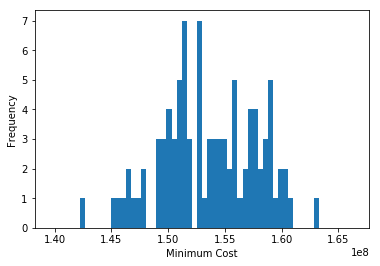

In [95]:
plt.hist(minimum_cost, bins = 60, range = (min(minimum_cost)*0.98, max(minimum_cost)*1.02))
plt.xlabel('Minimum Cost')
plt.ylabel('Frequency')
plt.show()